In [141]:
import os
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
from IPython.display import clear_output

# modify to where you store your project data including utils.py
datadir = ""
utilfn = datadir + "utils.py" 
!cp "$utilfn" .
import utils

cp: 'utils.py' and './utils.py' are the same file


[]

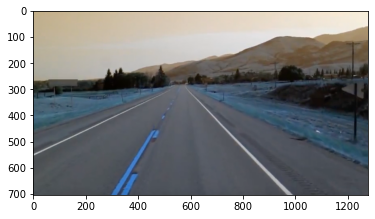

In [138]:
# images location
im1 = './images/lane_sample_3.jpeg'

# Load an color image in grayscale
im1 = cv2.imread(im1)

plt.imshow(im1)
plt.plot()

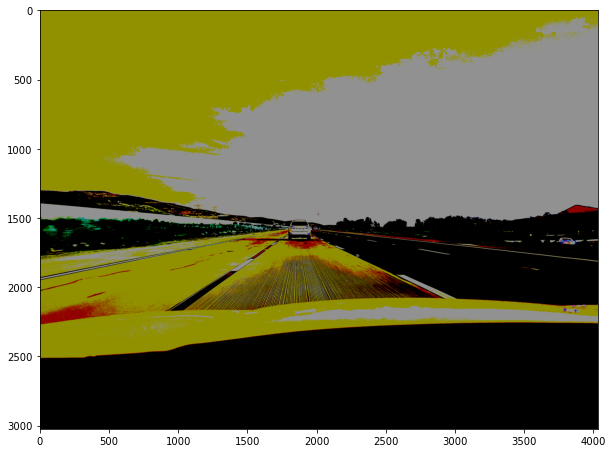

In [3]:
# apply image thresholding
ret, thresh = cv2.threshold(im1, 130, 145, cv2.THRESH_BINARY)
# plot image
plt.figure(figsize=(10,10))
plt.imshow(thresh, cmap= "gray")
plt.show()

In [3]:
def specify_mask(img):
    # get mask
    print("If it doesn't get you to the drawing mode, then rerun this function again.")
    fig = plt.figure()
    fig.set_label('Draw polygon around source object')
    plt.axis('off')
    plt.imshow(img, cmap='gray')
    xs = []
    ys = []
    clicked = []

    def on_mouse_pressed(event):
        x = event.xdata
        y = event.ydata
        xs.append(x)
        ys.append(y)
        plt.plot(x, y, 'r+')
#         print(x, y)

    def onclose(event):
        clicked.append(xs)
        clicked.append(ys)
    # Create an hard reference to the callback not to be cleared by the garbage
    # collector
    fig.canvas.mpl_connect('button_press_event', on_mouse_pressed)
    fig.canvas.mpl_connect('close_event', onclose)
    return clicked

def get_mask(ys, xs, img):
    mask = poly2mask(ys, xs, img.shape[:2]).astype(int)
    fig = plt.figure()
    plt.imshow(mask, cmap='gray')
#     plt.show()
    return mask

def poly2mask(vertex_row_coords, vertex_col_coords, shape):
    fill_row_coords, fill_col_coords = draw.polygon(vertex_row_coords, vertex_col_coords, shape)
    mask = np.zeros(shape, dtype=np.bool)
    mask[fill_row_coords, fill_col_coords] = True
    return mask

In [128]:
def region_of_interest(image):

#     # create a zero array
#     stencil = np.zeros_like(image[:,:])

#     # specify coordinates of the polygon
#     # polygon = np.array([[50,270], [220,160], [360,160], [480,270]])
#     %matplotlib notebook
#     polygon = specify_mask(image)
    
#     print(polygon)

#     # fill polygon with ones
#     cv2.fillConvexPoly(stencil, polygon, 1)

#     return stencil

    height, width = image.shape
#     polygons = np.array([
#         [(200, height), (1100, height), (550, 250)]
#         ])
    polygons = np.array([
        [(-int(width/2), height), (width+int(width/2), height), (int(image.shape[1]/2), int(image.shape[0]/4))]
        ])
    mask = np.zeros_like(image)
      
    # Fill poly-function deals with multiple polygon
    cv2.fillPoly(mask, polygons, 255) 
    
    plt.imshow(mask)
    plt.show()
      
    # Bitwise operation between canny image and mask image
    masked_image = cv2.bitwise_and(image, mask) 
    return masked_image

In [5]:
def canny_edge_detector(image):
    
    print(image.shape)
      
    # Convert the image color to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) 
    
#     print(gray_image.shape)
      
    # Reduce noise from the image
    blur = cv2.GaussianBlur(gray_image, (5, 5), 0) 
    canny = cv2.Canny(blur, 50, 150)
    
    im_final = np.zeros_like(image)
    im_final[:,:,0] = canny
    im_final[:,:,1] = canny
    im_final[:,:,2] = canny
    
#     print(im_final.shape)
    return canny

In [6]:
def create_coordinates(image, line_parameters):
    print(line_parameters)
    slope, intercept = line_parameters
    y1 = image.shape[0]
    y2 = int(y1 * (3 / 5))
    x1 = int((y1 - intercept) / slope)
    x2 = int((y2 - intercept) / slope)
    return np.array([x1, y1, x2, y2])

In [7]:
def average_slope_intercept(image, lines):
    left_fit = []
    right_fit = []
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
          
        # It will fit the polynomial and the intercept and slope
        parameters = np.polyfit((x1, x2), (y1, y2), 1) 
        slope = parameters[0]
        intercept = parameters[1]
        if slope < 0:
            left_fit.append((slope, intercept))
        else:
            right_fit.append((slope, intercept))
              
    left_fit_average = np.average(left_fit, axis = 0)
    right_fit_average = np.average(right_fit, axis = 0)
    print(left_fit, right_fit)
    print(left_fit_average, right_fit_average)
    left_line = create_coordinates(image, left_fit_average)
    right_line = create_coordinates(image, right_fit_average)
    return np.array([left_line, right_line])

In [8]:
def display_lines(image, lines):
    line_image = np.zeros_like(image)
    if lines is not None:
        for x1, y1, x2, y2 in lines:
            cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 10)
    return line_image

In [75]:
def delete_per_row_3D_view(a, remove_idx):
    m,n,r = a.shape
    mask = np.ones((m,n),dtype=bool)
    mask[np.arange(len(remove_idx)), remove_idx] = False
    vd = np.dtype((np.void, a.dtype.itemsize * r))
    a_masked = np.ascontiguousarray(a).view(vd).ravel()[mask.flat].view(a.dtype)
    return a_masked.reshape(m,-1,r)

(499, 804, 3)
(499, 804)
If it doesn't get you to the drawing mode, then rerun this function again.


<IPython.core.display.Javascript object>


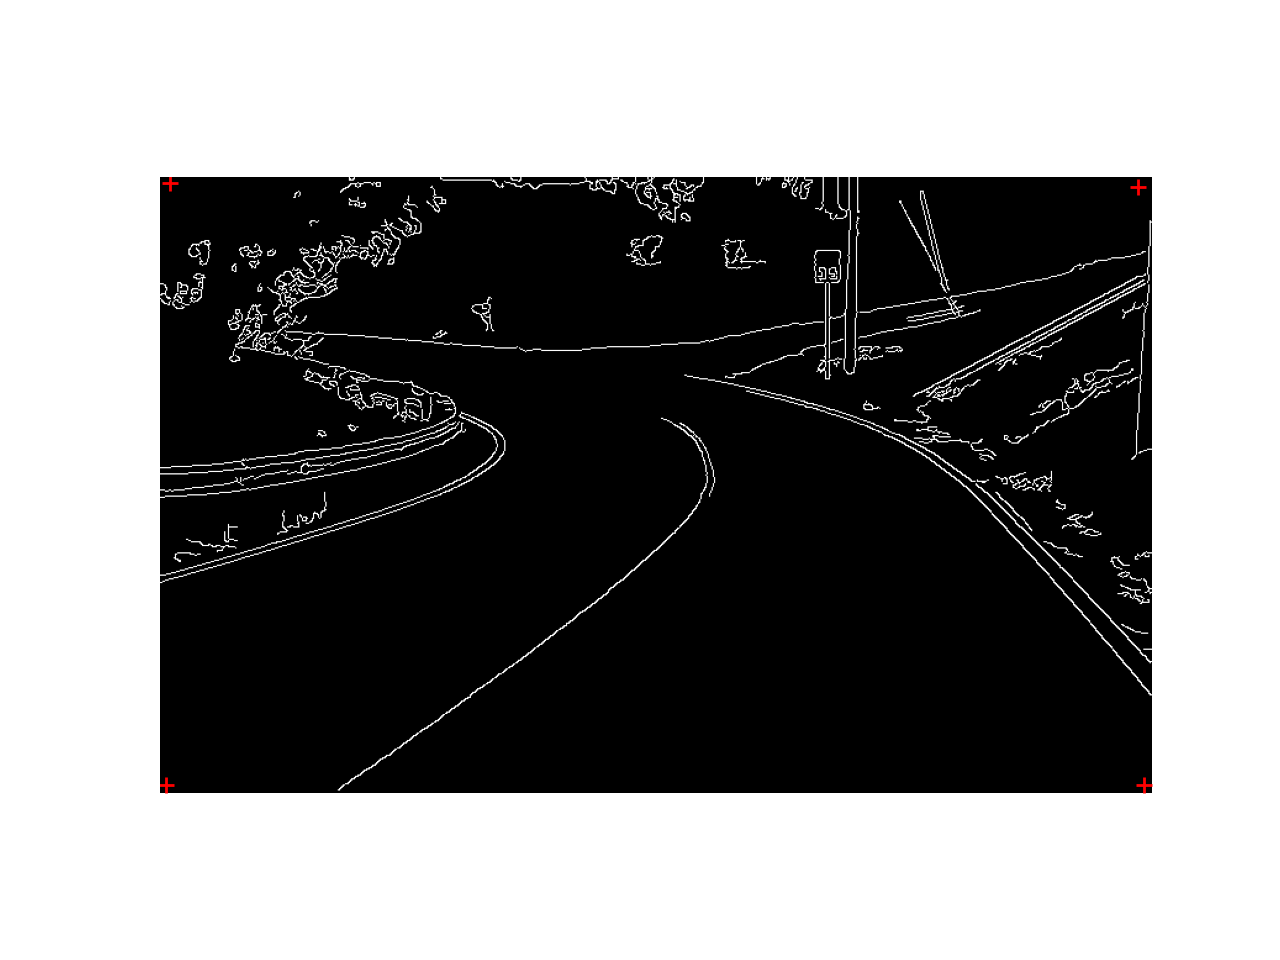

In [103]:
%matplotlib notebook
im_canny = canny_edge_detector(im1)
print(im_canny.shape)
polygon = utils.specify_mask(im_canny)

(704, 1279, 3)
[[  4   7 792 796]
 [492   4   7 492]
 [  4   7 792 796]
 [492   4   7 492]]
here


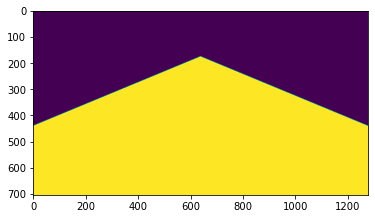

(704, 1279)


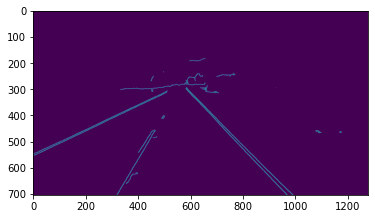

(704, 1279)


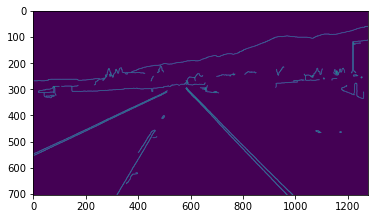

(704, 1279)


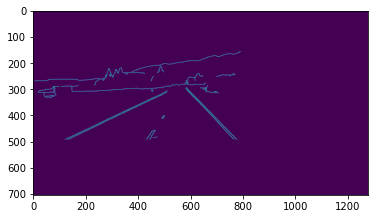

In [139]:
xs = polygon[0]
ys = polygon[1]
%matplotlib inline
object_mask = utils.get_mask(ys, xs, im1)

im_canny = canny_edge_detector(im1)

print(np.array(polygon, dtype=np.int32))

polygons = np.array([
        [(polygon[0][0], polygon[1][0]), (polygon[0][1], polygon[1][1]), (polygon[0][2], polygon[1][2]), (polygon[0][3], polygon[1][3])]
        ])

mask = np.zeros_like(im_canny)

print("here")
      
# Fill poly-function deals with multiple polygon
cv2.fillPoly(mask, np.array(polygons, dtype=np.int32), 255) 

im_roi_new = cv2.bitwise_and(im_canny, mask) 

# object_mask_3_channel = np.zeros_like(im_canny)
# object_mask_3_channel[:,:,0] = object_mask
# object_mask_3_channel[:,:,1] = object_mask
# object_mask_3_channel[:,:,2] = object_mask

# im_canny = im_canny * object_mask_3_channel
im_roi = region_of_interest(im_canny)
print(im_roi.shape)
plt.imshow(im_roi)
plt.show()

print(im_canny.shape)

plt.imshow(im_canny)
plt.show()

# print(im_canny.shape, object_mask.shape)
# im_roi_new = cv2.bitwise_and(im_canny, object_mask)

print(im_roi_new.shape)
plt.imshow(im_roi_new)
plt.show()

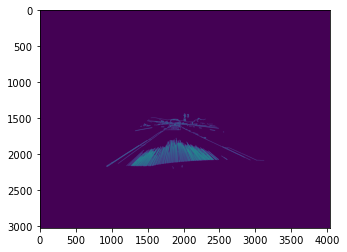

(3024, 4032)
(3024, 4032)


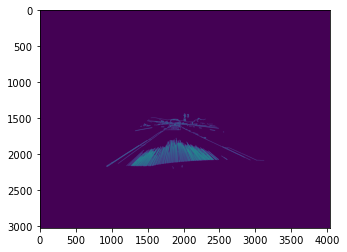

In [18]:
# old_polygon = np.trunc(polygon)
# polygon = np
xs = polygon[0]
ys = polygon[1]
%matplotlib inline
object_mask = utils.get_mask(ys, xs, im1)

object_mask_3_channel = np.zeros_like(im_canny)
object_mask_3_channel[:,:,0] = object_mask
object_mask_3_channel[:,:,1] = object_mask
object_mask_3_channel[:,:,2] = object_mask

# print(polygon)

'''
print(object_mask.shape)

plt.imshow(object_mask)
plt.show()

im_roi = im1
for i in range(3):
    im_roi[:,:,i] = im1[:,:,i] * object_mask
    
# plt.imshow(im_canny)
# plt.show()
# im_roi = canny_edge_detector(im_canny)

# im_roi = im_canny * object_mask
# im_roi = cv2.bitwise_and(im_canny, object_mask) 
plt.imshow(im_roi)
plt.show()

im_roi = canny_edge_detector(im_roi)
plt.imshow(im_roi)
plt.show()
'''

im_canny = canny_edge_detector(im1) * object_mask
plt.imshow(im_canny)
plt.show()

# im_roi = region_of_interest(im_canny)

print(np.array(im_canny).shape)
print(np.array(object_mask).shape)

# print(object_mask)
# print(im_canny)

# create a zero array
stencil = np.zeros_like(im_canny[:,:])

# fill polygon with ones
# cv2.fillConvexPoly(stencil, np.array(polygon), 'int32', 1)

# diff = cv2.absdiff(np.array(im_canny), np.array(object_mask))
# print(diff)
im_roi = cv2.bitwise_and(np.array(im_canny), np.array(object_mask))

# im_roi = region_of_interest(im_canny, np.array(polygon))

plt.imshow(im_roi)
plt.show()

(704, 1279)
(25, 1, 4)
(0, 1, 4)


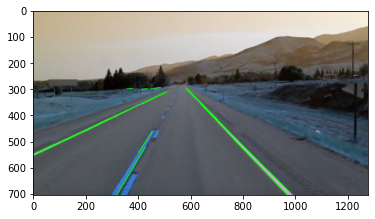

[(-0.4691358024691365, 547.9999999999999), (-0.48648648648648607, 558.3243243243242), (-0.4832214765100676, 552.1342281879197), (-0.48421052631578876, 555.5578947368423), (-1.6636363636363614, 1235.3636363636351), (-0.47033898305084715, 548.9322033898304), (-0.4842105263157888, 559.4315789473679), (-0.47572815533980656, 555.1844660194179), (-1.547169811320754, 1163.9622641509432), (-0.46902654867256643, 549.0176991150443), (-0.045454545454547725, 318.86363636363745), (-0.151515151515151, 367.18181818181785), (-0.4814814814814793, 556.1851851851845), (-0.15000000000000094, 367.05000000000047), (-0.047619047619047894, 316.0476190476191), (-0.47222222222222293, 553.9444444444445)] [(1.0000000000000016, -286.0000000000012), (1.0346534653465342, -300.5792079207911), (1.0000000000000018, -289.0000000000011), (1.0285714285714336, -300.7142857142891), (1.0303030303030336, -301.3333333333358), (0.9999999999999989, -287.9999999999993), (1.0476190476190592, -312.7619047619118), (0.999999999999999

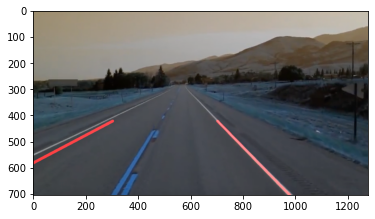

In [140]:
# im_canny = canny_edge_detector(im1)
# im_roi = region_of_interest(im_canny)

# im_roi = cv2.cvtColor(im_roi, cv2.COLOR_RGB2GRAY) 
# im_roi = canny_edge_detector(im_roi)

# plt.imshow(im_roi)
# plt.show()
# plt.imshow(im_canny)
# plt.show()

# im_roi = im_canny

print(im_roi.shape)

im_mod = im1.copy()

lines = cv2.HoughLinesP(im_roi, 2, np.pi / 180, 100, 
                            np.array([]), minLineLength = 20, 
                            maxLineGap = 5) 

print(lines.shape)

lines_reduced = lines.copy()
lines_x = lines[:,:,0].reshape(lines.shape[0])
line = 0

while True:
    if line >= lines_reduced.shape[0]:
        break
#     print("here")
    lines_x_rem = np.delete(lines_x, line)
#     print(min(abs(lines_x_rem - lines[line,0,0])))
    if min(abs(lines[:][0] - lines[line][0])).any() < 5:
#         lines_reduced = np.delete(lines_reduced, line, axis=0)
#         lines_reduced = np.delete(lines_reduced, np.argwhere(lines_reduced == lines[line]), axis=0)
        lines_reduced = np.delete(lines_reduced, line, axis=0)
    else: 
        line += 1

print(lines_reduced.shape)

for x in range(0, len(lines)):
    for x1,y1,x2,y2 in lines[x]:
        cv2.line(im_mod,(x1,y1),(x2,y2),(0,255,0),2)

# cv2.imshow('hough',im1)
plt.imshow(im_mod)
plt.show()

averaged_lines = average_slope_intercept(im1, lines) 
line_image = display_lines(im1, averaged_lines)
combo_image = cv2.addWeighted(im1, 0.8, line_image, 1, 1) 
# cv2.imshow("results", combo_image)
plt.imshow(combo_image)
plt.show()

# plt.imshow(im_roi)
# plt.show()
# plt.imshow(im_canny)
# plt.show()

In [ ]:
lines = cv2.HoughLinesP(thresh, 1, np.pi/180, 30, maxLineGap=200)
# create a copy of the original frame
dmy = col_images[idx][:,:,0].copy()
# draw Hough lines
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(dmy, (x1, y1), (x2, y2), (255, 0, 0), 3)
# plot frame
plt.figure(figsize=(10,10))
plt.imshow(dmy, cmap= "gray")
plt.show()